# Find initial conditions for $$a_0$$ by optimizing the KdV model

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV


import matplotlib as mpl

import yaml

In [4]:
%matplotlib notebook

In [5]:

def double_tanh_6(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[2,...] + beta[4,...])/beta[5,...]))


# In[118]:


def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]



In [96]:
# Load the csv file with the representative beta's and target A_max
csvfile = '../data/vkdv_inputs.csv'
depthfile = '../data/kdv_bathy_Prelude.csv'
infile = '../data/kdvin.yml'

#pd.read_csv?
data = pd.read_csv(csvfile, sep=', ', parse_dates=['time','timemax'])

data.head()

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,time,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5
0,2016-11-01,2016-11-01 05:47:00,-22.350,1023.362,1.278,74.247,70.383,80.389,66.281
1,2016-11-02,2016-11-02 17:53:00,-24.940,1023.335,1.278,72.685,74.638,78.732,63.247
2,2016-11-03,2016-11-03 12:05:00,27.269,1023.336,1.279,71.652,78.678,80.891,58.666
3,2016-11-04,2016-11-04 18:24:00,-26.743,1023.328,1.279,70.576,82.375,84.187,52.932
4,2016-11-05,2016-11-05 06:20:00,-24.843,1023.332,1.278,70.387,80.803,85.741,49.936


In [67]:
np.argwhere(data['Amax']==data['Amax'].min())
data['Amax'][153]

-67.605

In [83]:
def zeroic(x, a_0, L_w, x0=0.):
    return 0*x
def start_kdv(infile, rho, z, depthfile):
    # Parse the yaml file
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})
        kdvargs.update({'verbose':False})

        runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']


    # Parse the density and depth files
    depthtxt = np.loadtxt(depthfile, delimiter=',')

    # Initialise the KdV class
    mykdv = vKdV(rho,\
        z,\
        depthtxt[:,1],\
        x=depthtxt[:,0],\
        **kdvargs)

    return mykdv


def run_vkdv(a0,mykdv, infile, verbose=True):
    
    # Need to reset the amplitude variables and time step
    mykdv.B *= 0 
    mykdv.B_n_m1 *= 0
    mykdv.B_n_m2 *= 0
    mykdv.B_n_p1 *= 0
    mykdv.t = 0
    
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})

        runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']
        
    # Find the index of the output point
    idx = np.argwhere(mykdv.x > xpt)[0][0]

    # Initialise an output array
    nsteps = int(runtime//mykdv.dt_s)
    nout = int(runtime//ntout)
    B = np.zeros((nout, mykdv.Nx)) # Spatial amplitude function
    tout = np.zeros((nout,))

    B_pt = np.zeros((nsteps, )) # Spatial amplitude function
    tfast = np.zeros((nsteps,))

    output = []

    def bcfunc(t):
        omega = 2*np.pi/(12.42*3600.)
        return -a0*np.sin(omega*t)
        

    ## Run the model
    nn=0
    for ii in range(nsteps):
        # Log output
        point = nsteps//100
        if verbose:
            if(ii % (5 * point) == 0):
                 print( '%3.1f %% complete...'%(float(ii)/nsteps*100))
                 print(mykdv.B.max(), bcfunc(mykdv.t))

        if mykdv.solve_step(bc_left=bcfunc(mykdv.t)) != 0:
            print( 'Blowing up at step: %d'%ii)
            break
        
        ## Evalute the function
        #if myfunc is not None:
        #    output.append(myfunc(mykdv))

        # Output data
        if (mykdv.t%ntout) < mykdv.dt_s:
            #print ii,nn, mykdv.t
            B[nn,:] = mykdv.B[:]
            tout[nn] = mykdv.t
            nn+=1

        # Output single point
        B_pt[ii] = mykdv.B[idx]
        tfast[ii] = mykdv.t

    # Save to netcdf
    ds = mykdv.to_Dataset()
    
    xray = xr

    # Create a dataArray from the stored data
    coords = {'x':mykdv.x, 'time':tout}
    attrs = {'long_name':'Wave amplitude',\
            'units':'m'}
    dims = ('time','x')

    Bda = xray.DataArray(B,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    coords = {'timefast':tfast}
    attrs = {'long_name':'Wave Amplitude Point',
            'units':'m',
            'x-coord':xpt}
    dims = ('timefast',)
    Bpt = xray.DataArray(B_pt,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    ds2 = xray.Dataset({'B_t':Bda,'B_pt':Bpt})
    #return ds2.merge( ds, inplace=True )
    #return ds.merge(ds2, inplace=True)
    #return ds.merge( xray.Dataset({'B_t':Bda,'B_pt':Bpt}), inplace=False )
    
    return maximum_amplitude_finder(B_pt)[0], ds2.merge( ds, inplace=True )




<IPython.core.display.Javascript object>


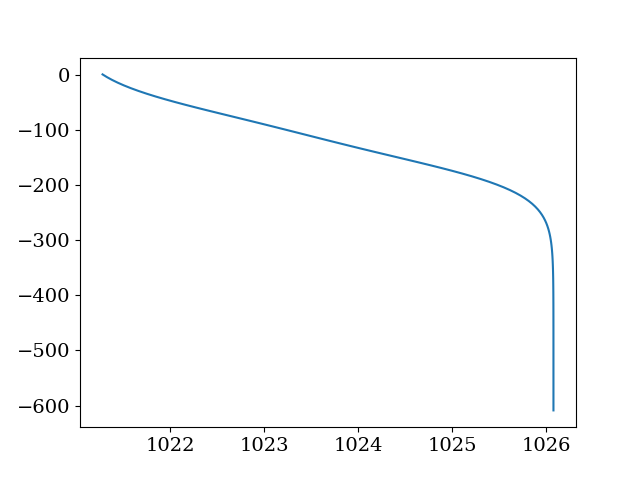

In [69]:
depthtxt = np.loadtxt(depthfile, delimiter=',')
z = np.arange(-depthtxt[0,1],5,5)[::-1]

# For each time step
tt = 153

# Load beta and Amax
beta = np.array([data['beta0'][tt], data['beta1'][tt],data['beta2'][tt],data['beta3'][tt],data['beta4'][tt],data['beta5'][tt]])
Amax = data['Amax'][tt]
rho = double_tanh_6(beta,z)

plt.figure()
plt.plot(rho,z)

In [70]:
%%time
# Launch a KdV instance
mykdv =  start_kdv(infile, rho, z, depthfile)

Calculating eigenfunctions...
0.0 % complete...
10.0 % complete...
20.0 % complete...
30.0 % complete...
40.0 % complete...
50.0 % complete...
60.0 % complete...
70.0 % complete...
80.0 % complete...
90.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
10.0 % complete...
20.0 % complete...
30.0 % complete...
40.0 % complete...
50.0 % complete...
60.0 % complete...
70.0 % complete...
80.0 % complete...
90.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
CPU times: user 1min 1s, sys: 29 s, total: 1min 30s
Wall time: 23.8 s


In [72]:
%%time
# Testing only
Aguess, ds2 = run_vkdv( 30.0, mykdv, infile, verbose=False)
print(Aguess)

-38.45407432509057
CPU times: user 7.73 s, sys: 59.7 ms, total: 7.79 s
Wall time: 7.88 s


In [73]:
def fdiff(a0, Amax, mykdv, infile):

    Aguess,ds = run_vkdv(a0, mykdv, infile, verbose=False)
    
    # Change the sign Amax if the two aren't equal...
    if np.sign(Amax) != np.sign(Aguess):
        Amaxo = -1*Amax
    else:
        Amaxo = 1*Amax
        
    print(a0, Amaxo, Aguess )
    return (Aguess - Amaxo)**2.

In [75]:
%%time
# Testing only
fdiff( 34.21820833, Amax, mykdv, infile,)

34.21820833 -67.605 -50.60852468413386
CPU times: user 7.62 s, sys: 8.66 ms, total: 7.63 s
Wall time: 7.65 s


288.8801731628471

In [77]:
# Minimize
a0guess = min(np.abs(Amax),20)
soln = minimize(fdiff, a0guess, 
        args = (Amax,mykdv, infile),
        bounds=[(0,50.0)],
        method='SLSQP', options={'eps':1e-4, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

soln

[20.] -67.605 -24.801358948398573
[20.] -67.605 -24.848369085416937
[20.0001] -67.605 -24.84850147413989
[50.] -67.605 -115.35533143885034
[33.25215223] -67.605 -45.31983323234999
[33.25215223] -67.605 -45.31875301411152
[33.25225223] -67.605 -45.319172491363865
[49.99999995] -67.605 -115.35610425175915
[38.58729924] -67.605 -76.83322705042568
[38.58729924] -67.605 -76.83267589346907
[38.58739924] -67.605 -76.8332004605216
[36.7671984] -67.605 -66.56517979540325
[36.7671984] -67.605 -66.56509571510504
[36.7672984] -67.605 -66.56569495759788
[36.97472969] -67.605 -67.80093044791458
[36.97472969] -67.605 -67.80094020463676
[36.97482969] -67.605 -67.80153183572621
[36.94212913] -67.605 -67.6078622312138
[36.94212913] -67.605 -67.60786069751778
[36.94222913] -67.605 -67.6084535672545


     fun: 8.192367521233375e-06
     jac: array([0.03743536])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([36.94212913])

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:125: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


<IPython.core.display.Javascript object>


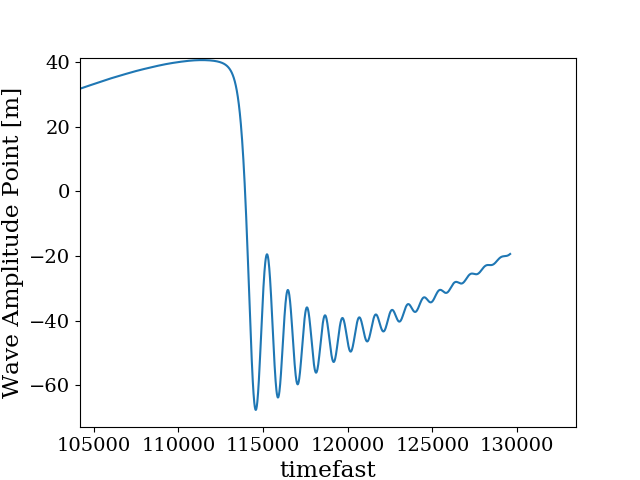

In [84]:
Aguess, ds2 = run_vkdv( soln['x'], mykdv, infile, verbose=False)

plt.figure()
ds2.B_pt.plot()

<IPython.core.display.Javascript object>


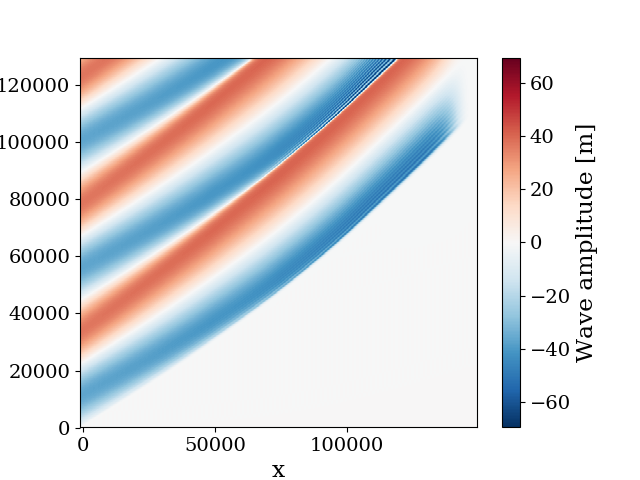

<xarray.Dataset>
Dimensions:   (time: 540, timefast: 8640, x: 3001, z: 123)
Coordinates:
  * x         (x) float64 -1e+03 -950.0 -900.0 ... 1.489e+05 1.49e+05 1.49e+05
  * time      (time) float64 240.0 480.0 720.0 ... 1.291e+05 1.294e+05 1.296e+05
  * timefast  (timefast) float64 15.0 30.0 45.0 ... 1.296e+05 1.296e+05
  * z         (z) float64 -0.0 -4.99 -9.981 -14.97 ... -598.8 -603.8 -608.8
Data variables:
    B_t       (time, x) float64 -1.168 -0.868 -0.5681 ... -0.000454 0.0
    B_pt      (timefast) float64 0.0 0.0 0.0 0.0 ... -19.56 -19.5 -19.44 -19.37
    B         (x) float64 22.05 22.24 22.44 22.67 ... -0.0009079 -0.000454 0.0
    Alpha     (x) float64 -0.007639 -0.007639 ... -0.0001103 -0.0001103
    Beta      (x) float64 1.53e+04 1.53e+04 1.53e+04 ... 2.977e+03 2.977e+03
    Qterm     (x) float64 1.0 1.0 1.0 0.9999 ... 0.5545 0.5545 0.5545 0.5545
    h         (x) float64 608.8 608.8 608.8 608.8 ... 231.0 231.0 231.0 231.0
    Cn        (x) float64 1.772 1.772 1.772 1.772 ..

In [85]:
plt.figure()
ds2.B_t.plot()
ds2

In [105]:
# Write to a file
outfile = '../data/kdv_optimal_a0_Prelude_%s.nc'%data['time'][tt].strftime('%Y-%m-%d')
ds2.to_netcdf(outfile)


-rwxrwxrwx 1 root root 36M Jun 12  2019 ../data/kdv_optimal_a0_Prelude_2017-04-03.nc


# Flat bottom optimizer

In [107]:
# Run the KdV solver
def runkdv(a0_sample, rho, z):
    def zeroic(x,a,L,x0=0):
        return 0*x

    kdvargs = dict(\
          verbose=False,\
          a0=a0_sample,\
          Lw=0.,\
          eigen_mde=eigen_mde,
          dt=20.,\
          nu_H=0.1,\
          ekdv=False,\
          wavefunc=zeroic,\
          spongedist = 10000.,\
          )
    #    print("p2 for a0 {}".format(a0_sample))
    omega = 2*np.pi/(12.42*3600)

    # No longer need this with zero initial conditions

    x_domain = np.arange(0,L_d+dx, dx)

    # Find the ouput x location
    xpt = np.argwhere(x_domain >= output_x)[0,0]

    # Boundary forcing function
    def sinebc(t):
        return a0_sample*np.sin(omega*t)

    # 8400 corresponds to the first grid point that is 1e5 meters away from
    # the initial point
    def amp_at_x(kdv):

        return kdv.B[xpt]

    #mykdv, B, output_amplitude = solve_kdv(iw_modes_output.rhoZ, iw_modes_output.Z, runtime,\
    mykdv, B, output_amplitude = solve_kdv(rho,
            z, 
            runtime,\
            solver='imex',\
            ntout=ntout, outfile=outfile,\
            x = x_domain,
            bcfunc=sinebc,
            myfunc=amp_at_x,\
            **kdvargs)
    
    return maximum_amplitude_finder(output_amplitude)


In [108]:
runkdv(35, rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

NameError: name 'rhobar' is not defined

<IPython.core.display.Javascript object>


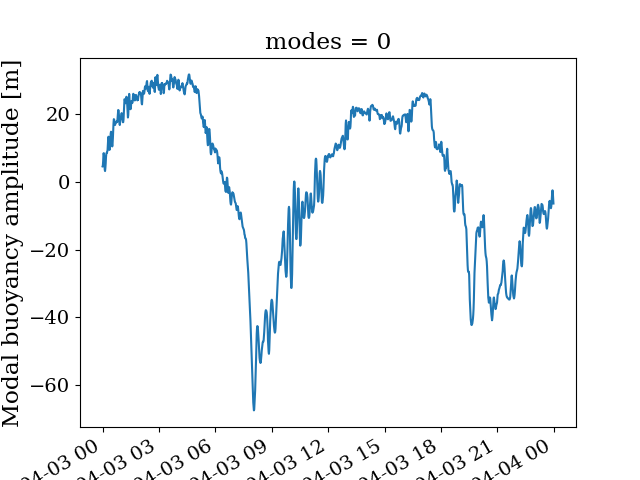

-67.60455940967898


In [107]:
Anow = A_n.sel(time='2017-04-03')
plt.figure()
Anow.plot()
print(maximum_amplitude_finder(Anow.values))


In [133]:
def fdiff(a0, A, rho, z):
    Amax = maximum_amplitude_finder(A.values)
    Aguess = runkdv(a0, rho, z)
    print(a0, Amax, Aguess )
    return (Aguess - Amax)**2.

#fdiff(30, A_n.sel(time='2017-04-01'),rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

In [144]:
minimize(fdiff, [30], 
        args = (A_n.sel(time='2017-02-13'),rhobar.sel(timeslow='2017-02-14 00:00:00').values, rhobar.z.values),
        bounds=[(0,np.abs(maximum_amplitude_finder(A_n.sel(time='2017-02-13').values)) )],
        method='SLSQP', options={'eps':1e-4, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

/home/suntans/code/iwaves/iwaves/kdv/solve.py:97: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  ds.merge( xray.Dataset({'B_t':Bda}), inplace=True )


[30.] -38.33124918310987 -30.049209481114485
[30.] -38.33124918310987 -30.049209481114485
[30.0001] -38.33124918310987 -30.049314410277695
[38.33124918] -38.33124918310987 -73.15153293740651
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83322492] -38.33124918310987 -30.92532892645022
[38.22774654] -38.33124918310987 -72.43582101100425
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57268708] -38.33124918310987 -31.752739068024106
[38.33124918] -38.33124918310987 -73.15153293738611
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24855329] -38.33124918310987 -33.5034015361953
[38.33124918] -38.33124918310987 -73.15153293740752
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85683288] -38.33124918310987 -36.632019620317514
[33.23684924] -38.3312

     fun: 0.00111838234653131
     jac: array([-0.3755506])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([33.16183621])

52.223896926957515